# Setup

## Load Modules

In [1]:
%matplotlib notebook

# Standard library
import os.path, logging, collections
import cPickle as pickle

# External modules
from neuron import h
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bluepyopt.ephys as ephys

# Our modules
from bgcellmodels.common import electrotonic, treeutils, analysis, logutils
from bgcellmodels.morphology import morph_ni, morph_gui

from bgcellmodels.models.GPe.Gunay2008 import gunay_pynn_model as gunay
from bgcellmodels.models.axon.mcintyre2002 import AxonMcintyre2002
from bgcellmodels.models.axon.foust2011 import AxonFoust2011

Using units module 'pint'


## Settings

In [2]:
# Global variables
nrnsim = ephys.simulators.NrnSimulator(dt=0.025, cvode_active=False)

logger = logging.getLogger('STN_MORPH')
logger.setLevel(logging.DEBUG)
logging.basicConfig(format=logutils.DEFAULT_FORMAT)

In [3]:
# Plotting options
page_width = 5.0
fig_aspect_ratio = 2.2 # 8.0 / 3.0
fig_width = 0.8 * page_width
fig_height = fig_width / fig_aspect_ratio

# Style of figures (default colors etc.): see https://matplotlib.org/gallery/style_sheets/style_sheets_reference.html
plt.style.use('default')

# fix bug for notebook backend where figures not shown
if matplotlib.get_backend() == 'nbAgg':
    from bgcellmodels.extensions.jupyter import jupyterutil
    jupyterutil.notebook_show_figs_after_exception()

## Functions

In [4]:
def get_sample(sec, i):
    return np.array([h.x3d(i, sec=sec), h.y3d(i, sec=sec), h.z3d(i, sec=sec), h.diam3d(i, sec=sec)])

def save_trace(trace_name, file_path, scale=1e-3):
    """
    Save trace to file
    """
    V_soma = np.array(vec_dict[trace_name], ndmin=2)
    T_soma = np.array(vec_dict['t_global'], ndmin=2)
    TV_soma = np.concatenate((T_soma, V_soma), axis=0) * scale # pyelectro expects SI units: seconds, Volts
    np.savetxt(file_path, TV_soma.T, delimiter=',', fmt=['%.3E', '%.7E'])
    print("Wrote trace to " + os.path.abspath(file_path))

## Measurement

In [5]:
electrotonic_measures = {
    'Ztransfer': {
        'function': electrotonic.measure_transfer_impedance,
        'label': 'Transfer impedance',
        'units': 'Ohm',
    },
    'Ai': {
        'function': electrotonic.measure_current_transfer,
        'label': 'Current transfer ratio',
        'units': 'ratio',
    },
    'Av': {
        'function': electrotonic.measure_voltage_transfer,
        'label': 'Voltage transfer ratio',
        'units': 'ratio',
    },
    'Zin': {
        'function': electrotonic.measure_input_impedance,
        'label': 'Input impedance',
        'units': 'Ohm',
    }
}

def plot_electrotonic_structure(root, leaves, measures=None, freq=25.0):
    """
    Plot electrotonic properties along dendritic paths.
    """
    if measures is None:
        plotted_measures = electrotonic_measures.keys()
    else:
        plotted_measures = measures
    measure_funcs = {measure: electrotonic_measures[measure]['function'] for measure in plotted_measures}
        
    # Do measurement
    leaf_path_measurements = electrotonic.measure_along_paths(root, leaves, measure_funcs, freq=freq)

    # Plot measurements
    fig, axes = plt.subplots(len(plotted_measures))

#     measures_ylims = {
#         'Ztransfer': (0, 50),
#         'Ai': (0.5, 1.05),
#         'Av': (0, 1.1),
#         'Zin': (0, 1000.0),
#     }

    for i, measure in enumerate(plotted_measures):
        ax = axes[i]

        # Plot the same measure for each leaf in the same axis
        for j, leaf in enumerate(leaves):
            ax.plot(leaf_path_measurements[j]['pathlen_micron'],
                    leaf_path_measurements[j][measure],
                    label=leaf.name())

            # ax.set_ylim(measures_ylims[measure])
            # ax.legend()
            ax.grid(True)
            ax.set_ylabel('{} ({})'.format(measure, electrotonic_measures[measure]['units']))
            ax.set_title(electrotonic_measures[measure]['label'])
    
    # prevent clipped xlabel
    # fig.subplots_adjust(hspace=0.5)
    # fig.tight_layout()
    return leaf_path_measurements

## Protocols

In [6]:
def setup_protocol_SPONT():
    """
    Edgerton 2010, Fig. 2

    Spontaneous firing for Arkypallidal cells in shown in:

        Abdi, Mallet et al (2015), Fig. 7 : f = 3 Hz
        Bogacz, Moraud, et al (2016), Fig. 3 : f = 2 Hz
    """
    h.dt = 0.025
    h.tstop = 1000.0
    
    h.celsius = 35.0
    h.v_init = -68.0
    
    h.init()
    # h.run()
    # nrnsim.run(h.tstop, h.dt)
    
    return {}


def setup_protocol_POSPULSE(icell):
    """
    Stimulation with 100 pA

    See article Gunay (2008), Fig. 1 and Fig. 2.
    """
    # Amplitude adjustment: soma surface was changed by factor 1 / 13.4^2 == pi*1^2 / pi*13.4^2
    # However: remaining compartments were changed by smaller factor, so this is not good adjustment
    surf_factor = 0.01
    stim = h.IClamp(soma(0.5))
    stim.delay = 1000
    stim.dur = 1000
    stim.amp = 0.1 * surf_factor # 100 pA = 0.1 nA

    h.dt = 0.025
    h.tstop = 3000.0
    
    h.celsius = 35.0
    h.v_init = -68.0
    
    h.init()
    
    return {'electrodes': [stim]}


def setup_protocol_NEGPULSE(icell):
    """
    Stimulation with -100 pA

    See article Gunay (2008), Fig. 1 and Fig. 2.
    """
    # Amplitude adjustment: soma surface was changed by factor 1 / 13.4^2 == pi*1^2 / pi*13.4^2
    # However: remaining compartments were changed by smaller factor, so this is not good adjustment
    surf_factor = 0.02
    stim = h.IClamp(soma(0.5))
    stim.delay = 1000
    stim.dur = 1000
    stim.amp = -0.1 * surf_factor # 100 pA = 0.1 nA
    
    h.dt = 0.025
    h.tstop = 3000.0
    
    h.celsius = 35.0
    h.v_init = -68.0
    
    h.init()
    
    return {'electrodes': [stim]}

def setup_protocol_ANTIDROMIC(cellmodel, amp=0.05, dur=200.0):
    """
    stimulation of axon.
    """
    sec = cellmodel.axon['node'][10]
    
    surf_factor = 1.0
    stim = h.IClamp(sec(0.5))
    stim.delay = 1000
    stim.dur = dur
    stim.amp = amp # (nA) e.g. 0.1 nA = 100 pA

    h.dt = 0.025
    h.tstop = 3000.0
    
    h.celsius = 35.0
    h.v_init = -68.0
    
    h.init()
    
    return {'electrodes': [stim]}

# Gunay (2008) cell

## Make Cell

In [7]:
# Load axon trajectory from diffusion streamlines
streamlines_path = '/home/luye/Documents/mri_data/Waxholm_rat_brain_atlas/WHS_DTI_v1_ALS/S56280_ROI-STN-bilateral.tck'
# axon_coords = morph_ni.load_streamlines(streamlines_path, max_num=1, min_length=2.0)[0]

# Load axon trajectory from Blender splines
axonfile_splines = ('/home/luye/workspace/bgcellmodels/bgcellmodels/models/network/'
                    'LuNetDBS/configs/axons/axon_coordinates_full.pkl')
with open(axonfile_splines, 'rb') as axon_file:
    all_axons = pickle.load(axon_file)
axon_coords = np.array(all_axons['axon.GPe-STN.nurbs.5']) * 1e-3

# Don't use axon
axon_coords = []

# Cell parameters
cell_params = dict(gunay.GpeProtoCellType.default_parameters)
cell_params['transform'] = np.eye(4)
cell_params['streamline_coordinates_mm'] = axon_coords
cell_params['axon_class'] = AxonFoust2011
cell_params['with_extracellular'] = False
cell_params['owning_gid'] = 1
## Parameters for gap junction connection
# Axon configuration
# - if gap_pre_conductance = 1e-5, spontaneous spiking unaffected but antidromic spikes do not trigger spike in soma
# - if gap_pre_conductance = 1e-4, antidromic spike results in dV of 2.5 mV in soma
# - if gap_pre_conductance = 5e-4, antidromic spike results in dV of 15 mV in soma, but no spike
# - if gap_pre_conductance = 1e-3, antidromic spike results in somatic spike
cell_params['axon_using_gap_junction'] = False
cell_params['gap_pre_conductance'] = 1e-5 # g=0 means unidirectional soma->axon
cell_params['gap_post_conductance'] = 1e-3
cell_params['axon_taper_diam'] = .005

# instantiate cell
model = gunay.GpeProtoCellType.model(**cell_params)
icell = model.icell

In [8]:
# Get sections by region
named_seclists =  {listname: list(getattr(icell, listname)) for listname in model.seclist_names}
for k, v in named_seclists.items():
    if len(v)==0:
        named_seclists.pop(k) # don't include empty SectionLists
    else:
        print("{} : {} sections".format(k, len(v)))

somatic = named_seclists['somatic']
dendritic = named_seclists['basal']

soma = somatic[0]
dend = dendritic[0]

if model.axon is not None:
    axonal = list(model.axon.all)
else:
    axonal = []

all : 41 sections
somatic : 1 sections
basal : 39 sections
axonal : 1 sections


In [9]:
# Representative sections picked from morphology viewer
distal_seg = dendritic[31](0.8)
middle_seg = dendritic[25](0.5)
proximal_seg = dendritic[0](0.5)

dend_leaf_secs = treeutils.leaf_sections(soma, subtree=True)
leaves = dend_leaf_secs
root = icell.soma[0]

rec_secs = {
    'soma': soma,
    'prox': proximal_seg,
    'mid': middle_seg,
    'dist': distal_seg,
    
}

if axonal:
    axon_leaf_secs = treeutils.leaf_sections(axonal[0], subtree=True)
    assert len(axon_leaf_secs) == 1, "More than one axon terminal section."
    axon_terminal = axon_leaf_secs[0]
    
    rec_secs.update({
        # Axon sections
        'ax_prox': model.axon['node'][3], # axonal[int(0.2 * len(axonal))],
        'ax_mid': model.axon['node'][6], # axonal[int(0.5 * len(axonal))],
        'ax_dist': model.axon['node'][9], # axonal[int(0.8 * len(axonal))],
        'ax_term': axon_terminal,
    })

# Protocols

## Cell Properties

In [10]:
# from neuron import gui
# h.topology()

In [11]:
# First draw skeleton to get an idea
# plt.figure()
# ax = plt.subplot(111, projection='3d')
# ax.view_init(90,90) # set azimut and elevation
# ax.set_zlim((-1,1)) # prevent rounding errors
# ax.set_axis_off() # hide x,y,z axes and grid

# # center = np.array([h.x3d(0, sec=soma), h.y3d(0, sec=soma), h.z3d(0, sec=soma)])
# x_soma = h.x3d(0, sec=soma)
# y_soma = h.y3d(0, sec=soma)
# ax.set_xlim((x_soma-200, x_soma+200))
# ax.set_ylim((y_soma-200, y_soma+200))


# # Plot shape of our cell
# morph_gui.shapeplot(h, ax)

# # Mark location of leaf section to refer to plots
# marker_colors = 'rgby'
# for i, leaf_sec in enumerate(leaves):
#     morph_gui.mark_locations(h, leaf_sec, 1.0, 
#                              label=leaf_sec.name(),
#                              markspec='o'+marker_colors[i])

# plt.legend()
# plt.show()

In [12]:
soma_Zin = {
    f : electrotonic.measure_input_impedance(soma(0.5), freq=f, linearize_gating=False)
                for f in (0.0, 100.0)
}

print("""Values without axon are:
        Zin(f=0.0) = 10244.5768497 (MOhm)
        Zin(f=100.0) = 514.248538756 (MOhm)\n""")

print("Somatic input impedances are: \n\t" + "\n\t".join(
        ["Zin(f={}) = {} (MOhm)".format(f, Z) for f,Z in soma_Zin.items()]))

# measurements = plot_electrotonic_structure(root, leaves)

Values without axon are:
        Zin(f=0.0) = 10244.5768497 (MOhm)
        Zin(f=100.0) = 514.248538756 (MOhm)

Somatic input impedances are: 
	Zin(f=0.0) = 11413.8613932 (MOhm)
	Zin(f=100.0) = 514.380922382 (MOhm)


## Recordings

In [13]:
trace_specs = collections.OrderedDict([
    ('t_global', {'var':'t'}),
    # Cell body and dendrites
    ('V_soma', {'var':'v', 'sec':'soma', 'loc':0.5}),
    ('V_prox', {'var':'v', 'seg':'prox'}),
    ('V_mid', {'var':'v', 'seg':'mid'}),
    ('V_dist', {'var':'v', 'seg':'dist'}),
    
])

if axonal:
    trace_specs.update([
        # Axonal sections
        ('V_axprox', {'var':'v', 'sec':'ax_prox', 'loc':0.5}),
        ('V_axmid', {'var':'v', 'sec':'ax_mid', 'loc':0.5}),
        ('V_axdist', {'var':'v', 'sec':'ax_dist', 'loc':0.5}),
        ('V_axterm', {'var':'v', 'sec':'ax_term', 'loc':0.5}),
    ])

# Record
rec_dt = 0.05
vec_dict, markers = analysis.recordTraces(rec_secs, trace_specs, rec_dt)

## Modify Cell

In [14]:
print("""Original:
-------------------------------

somatic:  	gmax_CaHVA = 0.000030
somatic:  	gmax_Kv4s = 0.003000
somatic:  	gmax_HCN = 0.000100
somatic:  	g_pas = 0.000068
somatic:  	gmax_NaF = 0.035000
somatic:  	gmax_HCN2 = 0.000250
somatic:  	gmax_KCNQ = 0.000200
somatic:  	gmax_SK = 0.006400
somatic:  	gmax_Kv4f = 0.002000
somatic:  	gmax_NaP = 0.000102
somatic:  	gmax_Kv2 = 0.000100
somatic:  	gmax_Kv3 = 0.001000

basal:  	gmax_CaHVA = 0.000030
basal:  	gmax_Kv4s = 0.006000
basal:  	gmax_HCN = 0.000100
basal:  	g_pas = 0.000068
basal:  	gmax_NaF = 0.035000
basal:  	gmax_HCN2 = 0.000250
basal:  	gmax_KCNQ = 0.000200
basal:  	gmax_SK = 0.000040
basal:  	gmax_Kv4f = 0.004000
basal:  	gmax_NaP = 0.000102
basal:  	gmax_Kv2 = 0.000100
basal:  	gmax_Kv3 = 0.001000

axonal:  	gmax_Kv4s = 0.240000
axonal:  	g_pas = 0.000068
axonal:  	gmax_NaF = 0.500000
axonal:  	gmax_KCNQ = 0.000040
axonal:  	gmax_Kv4f = 0.160000
axonal:  	gmax_NaP = 0.004000
axonal:  	gmax_Kv2 = 0.064000
axonal:  	gmax_Kv3 = 0.128000
""")

print("""Current:
-------------------------------""")

for seclist in 'somatic', 'basal', 'axonal':
    sections = list(getattr(icell, seclist))
    print('')
    for sec in sections:
        printed = False
        for mech, pnames in model._mechs_params_dict.items():
            rangevar = pnames[0] + '_' + mech
            if h.ismembrane(mech, sec=sec):
                print("%s:  \t%s = %f" % (seclist, rangevar, getattr(sec, rangevar)))
                printed = True
        if printed:
            break

Original:
-------------------------------

somatic:  	gmax_CaHVA = 0.000030
somatic:  	gmax_Kv4s = 0.003000
somatic:  	gmax_HCN = 0.000100
somatic:  	g_pas = 0.000068
somatic:  	gmax_NaF = 0.035000
somatic:  	gmax_HCN2 = 0.000250
somatic:  	gmax_KCNQ = 0.000200
somatic:  	gmax_SK = 0.006400
somatic:  	gmax_Kv4f = 0.002000
somatic:  	gmax_NaP = 0.000102
somatic:  	gmax_Kv2 = 0.000100
somatic:  	gmax_Kv3 = 0.001000

basal:  	gmax_CaHVA = 0.000030
basal:  	gmax_Kv4s = 0.006000
basal:  	gmax_HCN = 0.000100
basal:  	g_pas = 0.000068
basal:  	gmax_NaF = 0.035000
basal:  	gmax_HCN2 = 0.000250
basal:  	gmax_KCNQ = 0.000200
basal:  	gmax_SK = 0.000040
basal:  	gmax_Kv4f = 0.004000
basal:  	gmax_NaP = 0.000102
basal:  	gmax_Kv2 = 0.000100
basal:  	gmax_Kv3 = 0.001000

axonal:  	gmax_Kv4s = 0.240000
axonal:  	g_pas = 0.000068
axonal:  	gmax_NaF = 0.500000
axonal:  	gmax_KCNQ = 0.000040
axonal:  	gmax_Kv4f = 0.160000
axonal:  	gmax_NaP = 0.004000
axonal:  	gmax_Kv2 = 0.064000
axonal:  	gmax_Kv3 = 

In [15]:
# Change passive properties
axonal = list(icell.axonal)
ais_gunay = axonal[0]
ais_myelin = axonal[1]

IndexError: list index out of range

In [ ]:
# Adjust passive properties of cell body
# gpas_base = 6.80272108844e-05
# cm_base = 2.4

# for sec in [soma, ais_gunay]:
#     for seg in sec:
#         seg.g_pas = gpas_base / 1000.0
#         seg.cm = cm_base / 1000.0
            
# # Re-measure Zin
# Zin_0 = electrotonic.measure_input_impedance(
#         soma(0.5), freq=0, linearize_gating=False)
# Zin_100 = electrotonic.measure_input_impedance(
#         soma(0.5), freq=100, linearize_gating=False)
# print(Zin_0, Zin_100)

In [ ]:
# Adjust conductances
# Zin_reduction =  soma_Zin[0] / 10244.6 # Zin(f=0) new / old

# num_scaled = 0
# mechs_gbars = model._mechs_params_dict
# mechs_gbars.pop('leak', None)

# for sec in [soma, ais_gunay]:
#     for seg in sec:
#         for mech, gbars in mechs_gbars.items():
#             if h.ismembrane(mech, sec=sec):
#                 gname = gbars[0] + '_' + mech
#                 gval = getattr(seg, gname)
#                 setattr(seg, gname, gval / Zin_reduction)

## Protocol SPONT

In [16]:
# Edgerton 2010, Fig. 2
# Spontaneous firing for Arkypallidal cells in shown in:
#     - Abdi, Mallet et al (2015), Fig. 7 : f = 3 Hz
#     - Bogacz, Moraud, et al (2016), Fig. 3 : f = 2 Hz
setup_protocol_SPONT()
h.run()

0.0

<IPython.core.display.Javascript object>


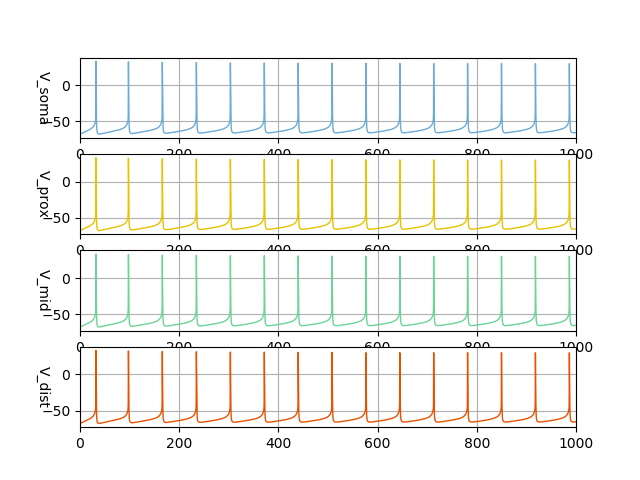

Wrote trace to /home/luye/workspace/bgcellmodels/bgcellmodels/models/GPe/Gunay2008/cellvalidation/v_soma_SPONT_mV_ms.csv


In [17]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True, excludeTraces='t_global')
# save_trace('V_soma', 'v_soma_SPONT_mV_ms.csv', scale=1.0)

## Protocol POSPULSE

In [18]:
# Stimulation with +100 pA
# See article Gunay (2008), Fig. 1 and Fig. 2.
protocol = setup_protocol_POSPULSE(icell)
h.run()

0.0

<IPython.core.display.Javascript object>


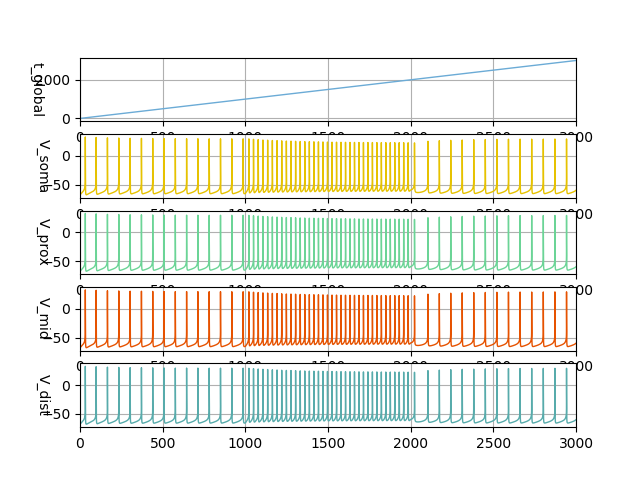

In [19]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

## Protocol NEGPULSE

In [21]:
# Stimulation with -100 pA
# See article Gunay (2008), Fig. 1 and Fig. 2.
protocol = setup_protocol_NEGPULSE(icell)
h.run()

0.0

<IPython.core.display.Javascript object>


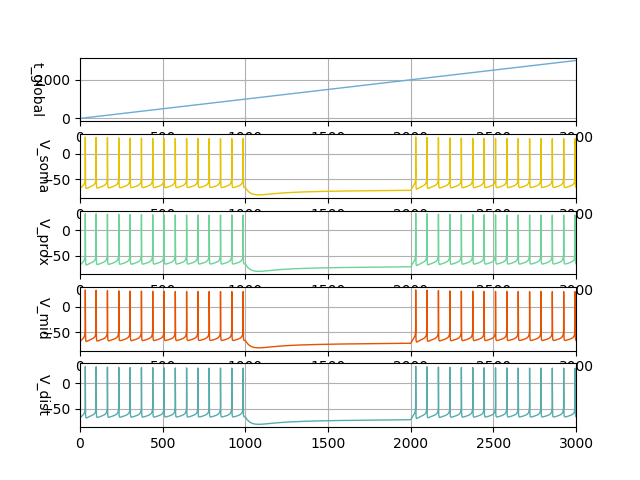

In [22]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

## Protocol ANTIDROMIC

In [ ]:
# Disable spontaneous spiking in
for sec in icell.all:
    if h.ismembrane('NaP', sec=sec):
        sec.gmax_NaP = 0.0

In [ ]:
protocol = setup_protocol_ANTIDROMIC(model, dur=5.0)
h.run()

In [ ]:
figs_vm = analysis.plotTraces(vec_dict, rec_dt, traceSharex=True)

# Save Notebook

In [ ]:
%%javascript
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});

In [ ]:
from datetime import datetime
nb_filename = 'calibrate_morphologies_GPe.ipynb'
report_filename = 'calibrate_morphologies_GPe_{}.html'.format(datetime.now().strftime('%Y.%m.%d_%H.%M.%S'))
!jupyter nbconvert $nb_filename --to html --template=toc2 --output $report_filename